## Importing Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

## Importing Dataset

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
df_ = pd.read_csv(r'hitters.csv')
df = df_.copy()

TARGET = "Salary"

## Task 1: Exploratory Data Analytics

### Step 1:  Examine the overall picture.

In [3]:
def check_df(dataframe, head = 5):

    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### nunique #####################")
    print(dataframe.nunique())

check_df(df)

##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        

### Step 2: Capture numeric and categorical variables.

In [4]:
def grab_col_names(dataframe, target, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.   

    Parameters
    ------
        dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
        target: str
                Dependent (target) variable

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols_mask = [col for col in dataframe.columns if dataframe[col].dtypes == "O"
                     and dataframe[col].nunique() < car_th and col != target]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O"
                   and dataframe[col].nunique() < cat_th and col != target]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and
                   col not in cat_cols_mask and col != target]

    cat_cols = cat_cols_mask + num_but_cat

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"
                and col not in num_but_cat and col != target]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, TARGET, cat_th=20)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 16
cat_but_car: 0
num_but_cat: 0


### Step 3: Analyze numeric and categorical variables.

Numerical columns:

In [5]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
AtBat,322.0,380.928571,153.404981,16.0,255.25,379.5,512.00,687.0
Hits,322.0,101.024845,46.454741,1.0,64.00,96.0,137.00,238.0
HmRun,322.0,10.770186,8.709037,0.0,4.00,8.0,16.00,40.0
Runs,322.0,50.909938,26.024095,0.0,30.25,48.0,69.00,130.0
RBI,322.0,48.027950,26.166895,0.0,28.00,44.0,64.75,121.0
Walks,322.0,38.742236,21.639327,0.0,22.00,35.0,53.00,105.0
Years,322.0,7.444099,4.926087,1.0,4.00,6.0,11.00,24.0
CAtBat,322.0,2648.683230,2324.205870,19.0,816.75,1928.0,3924.25,14053.0
CHits,322.0,717.571429,654.472627,4.0,209.00,508.0,1059.25,4256.0
CHmRun,322.0,69.490683,86.266061,0.0,14.00,37.5,90.00,548.0


count    322.000000
mean     380.928571
std      153.404981
min       16.000000
25%      255.250000
50%      379.500000
75%      512.000000
max      687.000000
Name: AtBat, dtype: float64


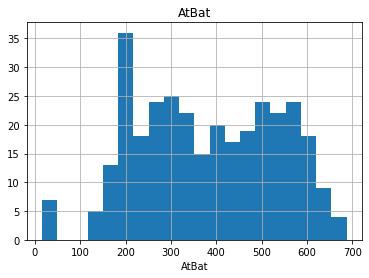

count    322.000000
mean     101.024845
std       46.454741
min        1.000000
25%       64.000000
50%       96.000000
75%      137.000000
max      238.000000
Name: Hits, dtype: float64


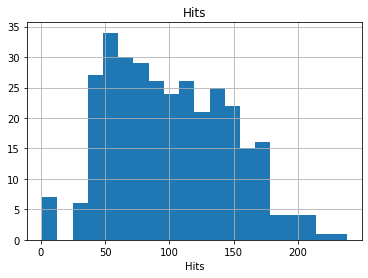

count    322.000000
mean      10.770186
std        8.709037
min        0.000000
25%        4.000000
50%        8.000000
75%       16.000000
max       40.000000
Name: HmRun, dtype: float64


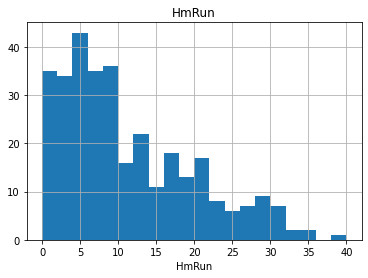

count    322.000000
mean      50.909938
std       26.024095
min        0.000000
25%       30.250000
50%       48.000000
75%       69.000000
max      130.000000
Name: Runs, dtype: float64


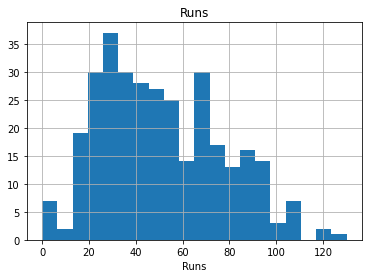

count    322.000000
mean      48.027950
std       26.166895
min        0.000000
25%       28.000000
50%       44.000000
75%       64.750000
max      121.000000
Name: RBI, dtype: float64


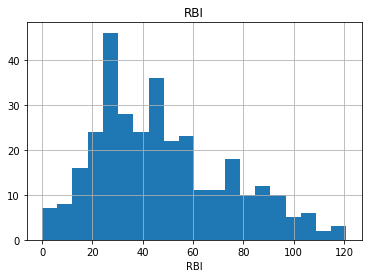

count    322.000000
mean      38.742236
std       21.639327
min        0.000000
25%       22.000000
50%       35.000000
75%       53.000000
max      105.000000
Name: Walks, dtype: float64


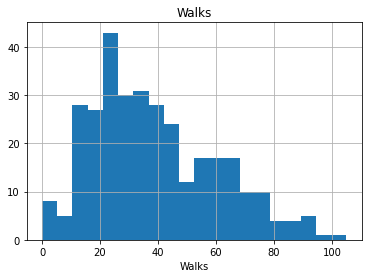

count    322.000000
mean       7.444099
std        4.926087
min        1.000000
25%        4.000000
50%        6.000000
75%       11.000000
max       24.000000
Name: Years, dtype: float64


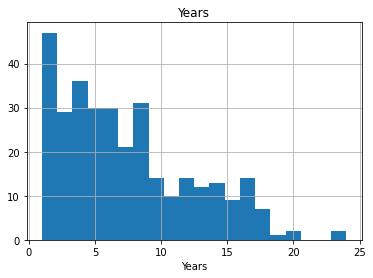

count      322.00000
mean      2648.68323
std       2324.20587
min         19.00000
25%        816.75000
50%       1928.00000
75%       3924.25000
max      14053.00000
Name: CAtBat, dtype: float64


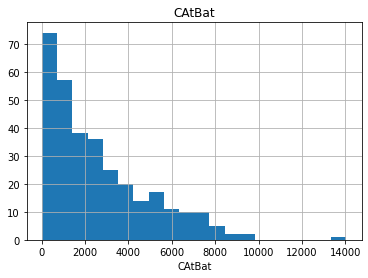

count     322.000000
mean      717.571429
std       654.472627
min         4.000000
25%       209.000000
50%       508.000000
75%      1059.250000
max      4256.000000
Name: CHits, dtype: float64


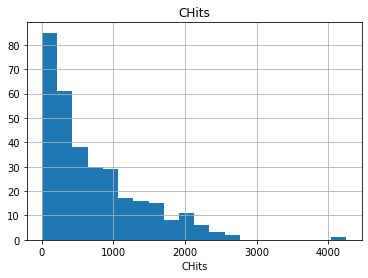

count    322.000000
mean      69.490683
std       86.266061
min        0.000000
25%       14.000000
50%       37.500000
75%       90.000000
max      548.000000
Name: CHmRun, dtype: float64


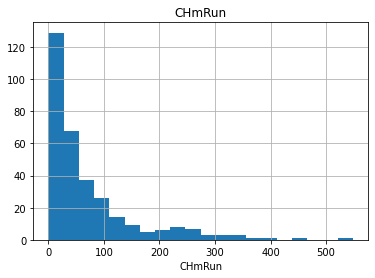

count     322.000000
mean      358.795031
std       334.105886
min         1.000000
25%       100.250000
50%       247.000000
75%       526.250000
max      2165.000000
Name: CRuns, dtype: float64


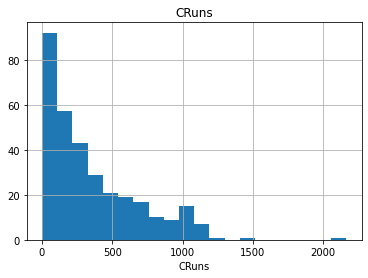

count     322.000000
mean      330.118012
std       333.219617
min         0.000000
25%        88.750000
50%       220.500000
75%       426.250000
max      1659.000000
Name: CRBI, dtype: float64


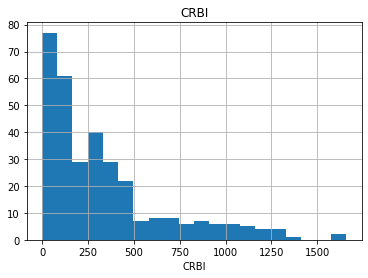

count     322.000000
mean      260.239130
std       267.058085
min         0.000000
25%        67.250000
50%       170.500000
75%       339.250000
max      1566.000000
Name: CWalks, dtype: float64


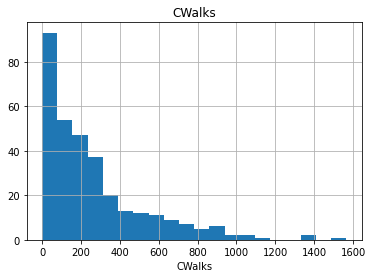

count     322.000000
mean      288.937888
std       280.704614
min         0.000000
25%       109.250000
50%       212.000000
75%       325.000000
max      1378.000000
Name: PutOuts, dtype: float64


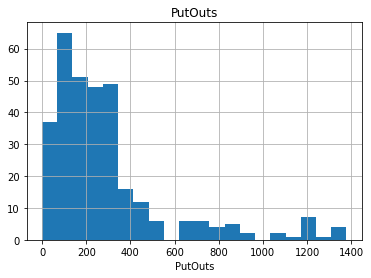

count    322.000000
mean     106.913043
std      136.854876
min        0.000000
25%        7.000000
50%       39.500000
75%      166.000000
max      492.000000
Name: Assists, dtype: float64


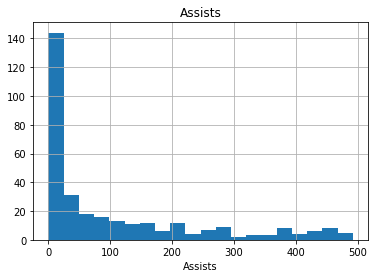

count    322.000000
mean       8.040373
std        6.368359
min        0.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       32.000000
Name: Errors, dtype: float64


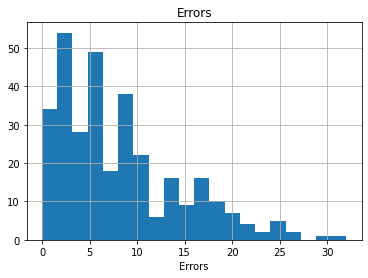

In [6]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.25, 0.50, 0.75]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

Categorical columns:

In [7]:
df[cat_cols].describe().T

,count,unique,top,freq
League,322,2,A,175
Division,322,2,W,165
NewLeague,322,2,A,176


   League      Ratio
A     175  54.347826
N     147  45.652174
##########################################


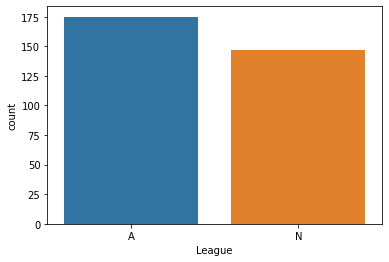

   Division      Ratio
W       165  51.242236
E       157  48.757764
##########################################


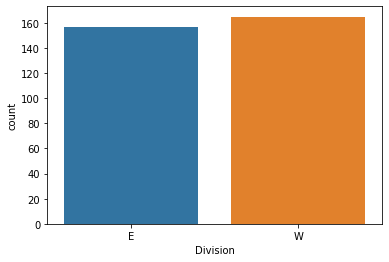

   NewLeague      Ratio
A        176  54.658385
N        146  45.341615
##########################################


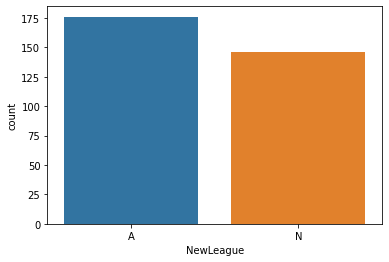

In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

### Step 4: Analyze the target variable (mean of the target variable according to categorical variables, mean of the numeric variables relative to the target variable)

Salary means based on categorical features (League, Division, NewLeage)

In [9]:
df.groupby(cat_cols)[TARGET].mean()

League  Division  NewLeague
A       E         A            660.433906
                  N            837.500000
        W         A            426.942791
                  N            278.750000
N       E         A            534.000000
                  N            575.772071
        W         A            438.000000
                  N            491.505759
Name: Salary, dtype: float64

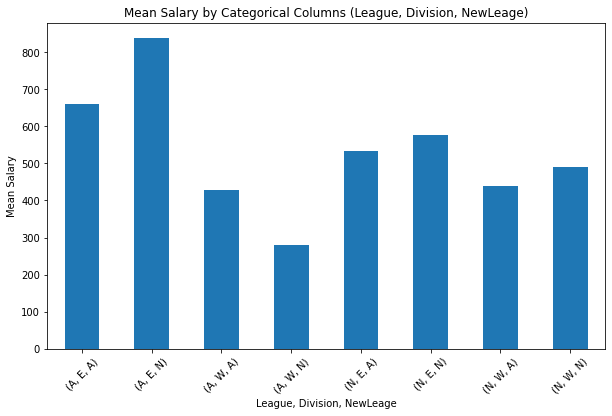

In [10]:
grouped_data = df.groupby(cat_cols)[TARGET].mean()
grouped_data.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Salary by Categorical Columns (League, Division, NewLeage)')
plt.xlabel('League, Division, NewLeage')
plt.ylabel('Mean Salary')
plt.xticks(rotation=45)
plt.show()

In [11]:
df[num_cols]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12


Most correlated numerical features with salary:

In [12]:
df.corr().abs()[TARGET].sort_values(ascending=False)[1:]

CRBI       0.566966
CRuns      0.562678
CHits      0.548910
CAtBat     0.526135
CHmRun     0.524931
CWalks     0.489822
RBI        0.449457
Walks      0.443867
Hits       0.438675
Runs       0.419859
Years      0.400657
AtBat      0.394771
HmRun      0.343028
PutOuts    0.300480
Assists    0.025436
Errors     0.005401
Name: Salary, dtype: float64

Text(0.5, 1.0, 'Correlation Heatmap')

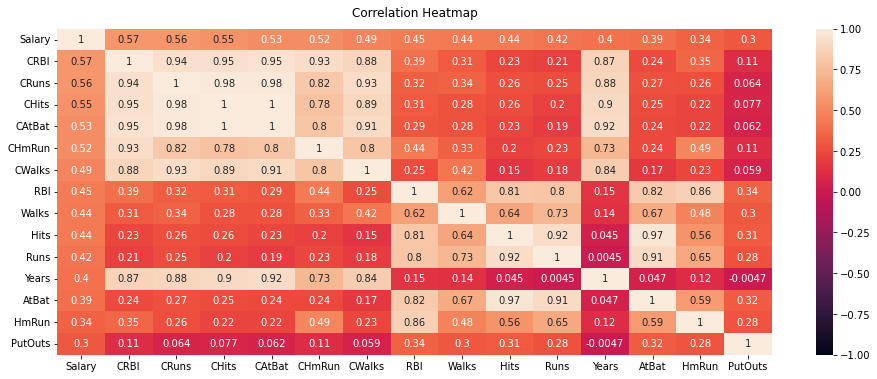

In [13]:
most_corr_features = df.corr().abs()[TARGET].sort_values(ascending=False)[:15].index

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[most_corr_features].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

### Step 5: Conduct outlier analysis.

In [14]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    '''
    This function calculates the lower and upper bounds for identifying outliers in a specified column of a DataFrame.

    Parameters:
    dataframe: The DataFrame containing the data.
    col_name: The name of the column for which you want to calculate outlier thresholds.
    q1 (default 0.25): The lower quartile (25th percentile) value used to calculate the lower limit.
    q3 (default 0.75): The upper quartile (75th percentile) value used to calculate the upper limit.
    '''

    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, print_values=False):
    '''
    This function checks for outliers in a specified column of a DataFrame using the thresholds calculated by the outlier_thresholds function.

    Parameters:
    dataframe: The DataFrame containing the data.
    col_name: The name of the column to check for outliers.
    print_values (default False): A boolean flag indicating whether to print the actual outlier values if any are found.
    '''

    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) |
                 (dataframe[col_name] < low_limit)].any(axis=None):
        if print_values:
            print(f'Values with higher values than upper limit in {col_name}:\n'
                  f'{dataframe.loc[dataframe[col_name] > up_limit, col_name]}\n')
            print(f'Values with lower values than lower limit in {col_name}:\n'
                  f'{dataframe.loc[dataframe[col_name] < low_limit, col_name]}\n',)
        else:
            print(f'There is outlined data in {col_name}')
        return True
    else:
        print(f'There is no outlined data in {col_name}')
        return False

In [15]:
for col in df[num_cols].columns:
    check_outlier(df, col, print_values=True)

There is no outlined data in AtBat
There is no outlined data in Hits
There is no outlined data in HmRun
There is no outlined data in Runs
There is no outlined data in RBI
There is no outlined data in Walks
There is no outlined data in Years
There is no outlined data in CAtBat
There is no outlined data in CHits
There is no outlined data in CHmRun
There is no outlined data in CRuns
There is no outlined data in CRBI
There is no outlined data in CWalks
There is no outlined data in PutOuts
There is no outlined data in Assists
There is no outlined data in Errors


### Step 6: Analyze missing observations.

In [16]:
def missing_values_table(dataframe, na_name=False):
    '''
    This Python function, missing_values_table, is designed to provide a summary of missing values in a DataFrame

    Parameters:
    dataframe: The DataFrame for which you want to analyze missing values.
    na_name (default False): A boolean flag that, when set to True, returns a list of column names with missing values.
    '''
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [17]:
features_with_missing = missing_values_table(df, na_name=True)

        n_miss  ratio
Salary      59  18.32


We have 3 different options for missing values:

- Rows with missing values could be deleted directly from the observation.
- The median or the mode value of the variable(column) could be assigned to the missing values.
- With a modeling like K-nearest neighbor, the closest rows to the row with the missing value would be detected and the value i closest row could be assigned to this missing value.

Because missing values caught from target feature ('Salary') the best option will be the first option to not the corrupt model with distorting target values.

In [18]:
df = df.dropna()
missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

## Task 2 : Feature Engineering

### Step 1: Take necessary actions for missing and outliers. 

Averages of seasonal values according to career values:

In [19]:
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Runs"] = df["Runs"] / df["CRuns"]
df["NEW_Hits"] = df['Hits'] / df['CHits']
df["NEW_HmRun"] = df["HmRun"] / df["CHmRun"]
df["NEW_Walks"] = df["Walks"] / df["CWalks"]
df["NEW_AtBat"] = df["AtBat"] / df["CAtBat"]

Success percentage of strokes:

In [20]:
df["NEW_Hits_Success_Ratio"] = (df["Hits"] / df["AtBat"])

In Feature Engineering process there could be created missing values:

In [21]:
missing_values_table(df, na_name=True)

           n_miss  ratio
NEW_HmRun       3   1.14


['NEW_HmRun']

Because there are 0 in "CHmRun", "HmRun" / "CHmRun" returned some None Values let's drop it

In [22]:
df = df.dropna()

Step 4: Standardize for numeric variables.

In [23]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Step 5: Encoding categoric variables.

In [24]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
for col in binary_cols:
    label_encoder(df, col)

## Task 3 : Machine Learning Model

### Step-1: Chosing the best Machine Learning model for the data-set:

In [25]:
y = df[TARGET]
X = df.drop([TARGET], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

for alg in [LinearRegression, GradientBoostingRegressor, RandomForestRegressor, LGBMRegressor, CatBoostRegressor, XGBRegressor]:

    model = alg(random_state = 33)
    if alg == CatBoostRegressor:
        model = alg(random_state = 33, verbose=False)
    cv_result = np.mean(np.sqrt(-cross_val_score(model,
                                 X_train,
                                 y_train,
                                 cv=10,
                                 scoring="neg_mean_squared_error")))

    print(f'RMSE of {type(model).__name__}: {cv_result}')

MSE of LinearRegression: 290.32769932506864


MSE of GradientBoostingRegressor: 296.376143121617
MSE of RandomForestRegressor: 305.0625413699896
MSE of LGBMRegressor: 317.349804290492
MSE of CatBoostRegressor: 301.77026217383235
MSE of XGBRegressor: 315.8978287627332


### Step 2: Fine tuning on best model

In [26]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

In [27]:
best_params

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [29]:
np.mean(np.sqrt(-cross_val_score(best_rf,
                                 X_train,
                                 y_train,
                                 cv=10,
                                 scoring="neg_mean_squared_error")))

303.020644599361

Test scores of tuned model:

In [34]:
y_pred = best_rf.predict(X_test)

print(f'mse: {mean_squared_error(y_test, y_pred)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'mae: {mean_absolute_error(y_test, y_pred)}')
print(f'r_squared: {r2_score(y_test, y_pred)}')

mse: 40264.547418388815
rmse: 200.66027862631114
mae: 129.09250121794872
r_squared: 0.649700267545239


Importance of Features:

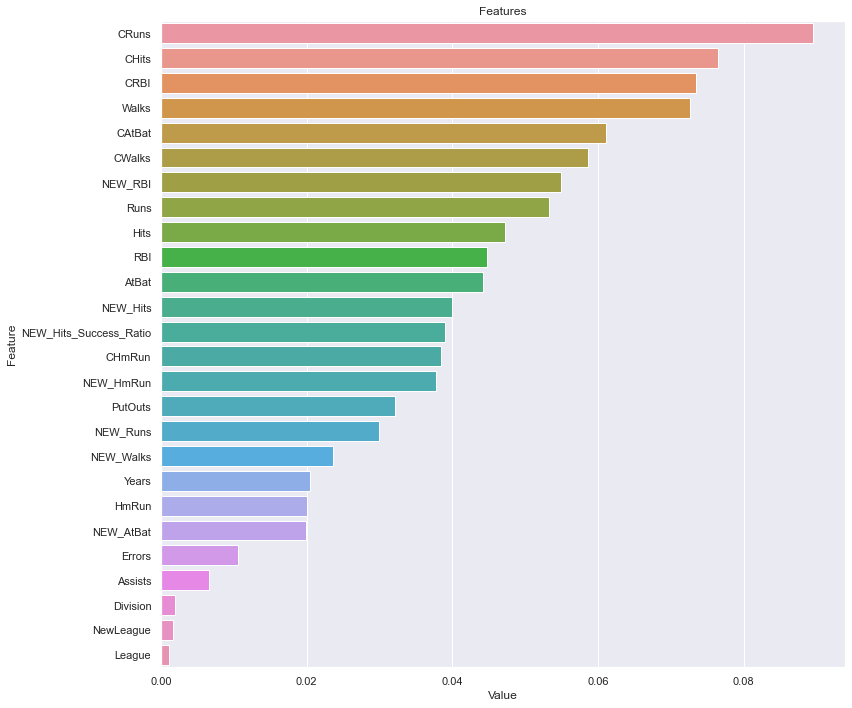

In [35]:
def plot_importance(model, features, num=len(X), save=False):
    plt.figure(figsize=(12, 10))
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(best_rf, X_train)